<a href="https://colab.research.google.com/github/sri299792458/stat8105_finetuning_paligemma/blob/main/big_vision/configs/proj/paligemma/finetune_paligemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune PaliGemma

> *These models and code are not official Google products and were trained and released for research purposes.*


**This notebook shows how to finetune PaliGemma 2 on a vision-language task.**
The training data consists of 90 pairs of images and long captions describing them.
To make it runnable on a T4 colab runtime with 16GB HBM and 12GB RAM, we opt to only finetune the attention layers of the language model and freeze the other parameters.

 **This setup is illustrative**. In a real usecase, the amount of data, trainable parameters, training steps and hyper-parameters and obtained results could be significantly different.

This notebook uses the model reference implementation from [big_vision](https://github.com/google-research/big_vision).
and shows how to:

 * Install deps, download model checkpoint and training data.
 * Load the model onto GPU devices.
 * Prepare the input to the model for training and inference.
 * Finetune the model and inspect output in validation split.

## Setup

In [1]:
# @title Fetch big_vision code and install dependencies.
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


In [2]:
# @title Download checkpoint, tokenizer and dataset using file IDs from Google Drive.
import os
import utils # Import the utils module

# Use these for PaliGemma-2 3B 224px²
LLM_VARIANT = "gemma2_2b"

# Define base directory relative to the current working directory
BASE_DIR = os.getcwd()
ASSETS_DIR = os.path.join(BASE_DIR, "paligemma_assets")
DATASET_DIR = os.path.join(BASE_DIR, "dataset")

# Create directories if they don't exist
os.makedirs(ASSETS_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)


MODEL_PATH = os.path.join(ASSETS_DIR, "paligemma2-3b-pt-224.b16.npz")
TOKENIZER_PATH = os.path.join(ASSETS_DIR, "paligemma_tokenizer.model")
DATASET_PATH = os.path.join(DATASET_DIR, "Cornell_Grasp_Kaggle_01")


# --- REPLACE WITH YOUR ACTUAL FILE IDs ---
CHECKPOINT_FILE_ID = 'YOUR_CHECKPOINT_FILE_ID'
TOKENIZER_FILE_ID = '1hHm9_CEReJYY7uEu-heTnbf30rXwO3gK'
DATASET_FILE_ID = '1ggLl8grjVWUcLaNbK8kmhTk5e8IZgW3g'

# Download and unzip the checkpoint
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Google Drive...")
  # Use the download_and_unzip function
  utils.download_and_unzip(CHECKPOINT_FILE_ID, ASSETS_DIR)
  print(f"Model path: {MODEL_PATH}")

# Download and unzip the tokenizer
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer from Google Drive...")
  # Use the download_and_unzip function
  utils.download_and_unzip(TOKENIZER_FILE_ID, ASSETS_DIR)
  print(f"Tokenizer path: {TOKENIZER_PATH}")

# Download and unzip the dataset
if not os.path.exists(DATASET_PATH):
  print("Downloading the dataset from Google Drive...")
  # Use the download_and_unzip function
  utils.download_and_unzip(DATASET_FILE_ID, DATASET_DIR)

## Notebook

In [3]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.5.3
JAX platform: gpu
JAX devices:  1


In [4]:
# @title Construct model and load params into RAM.

# Define model
# IMPORTANT: Gemma-2 has a "final_logits_softcap" property, we set it to 0.0
# for better transfer results.
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [5]:
# @title Move params to GPU/TPU memory.
#
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

#
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

In [6]:
# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [7]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [27]:
# ==============================================================================
# SECTION 1: CONSTANTS FOR DATA PREP
# ==============================================================================
import os
import glob
import random
import re
import itertools
from PIL import Image
from tqdm.notebook import tqdm

# Constants for our specific dataset and task
PROMPT_PREFIX = "detect grasp"
ORIGINAL_IMG_WIDTH = 640
ORIGINAL_IMG_HEIGHT = 480
SEQLEN = 64
IMAGE_SIZE = 224

# ==============================================================================
# SECTION 2: DATASET CREATION LOGIC
# ==============================================================================

def create_cornell_dataset(root_path):
    """
    Creates the full list of training examples from the Cornell Grasp dataset
    using the official PaliGemma detection format.
    """
    print(f"Searching for annotation files in: {root_path}")
    annotation_files = glob.glob(os.path.join(root_path, '**', '*cpos.txt'), recursive=True)

    data_examples = []
    skipped_files = 0

    print("Processing annotation files...")
    for txt_file in tqdm(annotation_files, desc="Processing files"):
        image_path = txt_file.replace('cpos.txt', 'r.png')
        if os.path.exists(image_path):
            try:
                with open(txt_file, 'r') as f:
                    lines = f.read().strip().split('\n')

                for i in range(0, len(lines), 4):
                    if i + 3 < len(lines):
                        coords = [lines[i+j].split() for j in range(4)]
                        x_coords = [float(p[0]) for p in coords]
                        y_coords = [float(p[1]) for p in coords]

                        xmin, ymin = min(x_coords), min(y_coords)
                        xmax, ymax = max(x_coords), max(y_coords)

                        loc_ymin = f"<loc{int((ymin / ORIGINAL_IMG_HEIGHT) * 1024)}>"
                        loc_xmin = f"<loc{int((xmin / ORIGINAL_IMG_WIDTH) * 1024)}>"
                        loc_ymax = f"<loc{int((ymax / ORIGINAL_IMG_HEIGHT) * 1024)}>"
                        loc_xmax = f"<loc{int((xmax / ORIGINAL_IMG_WIDTH) * 1024)}>"

                        suffix = f"{loc_ymin}{loc_xmin}{loc_ymax}{loc_xmax} grasp"
                        data_examples.append({'image_path': image_path, 'suffix': suffix})
            except Exception:
                skipped_files += 1
                continue

    if skipped_files > 0:
        print(f"  [!] Total skipped files due to errors: {skipped_files}")

    return data_examples

# ==============================================================================
# SECTION 3: DATA ITERATOR DEFINITIONS
# ==============================================================================

# 1. Create the full list of examples from our custom dataset
local_dataset_path = DATASET_PATH
all_examples = create_cornell_dataset(local_dataset_path)
random.shuffle(all_examples)



# 2. Split into training and validation sets
split_ratio = 0.9
split_idx = int(len(all_examples) * split_ratio)
train_examples = all_examples[:split_idx]
val_examples = all_examples[split_idx:]
print(f"\nDataset created: {len(train_examples)} training examples, {len(val_examples)} validation examples.")

# 3. Define the iterator functions with the required names
def train_data_iterator():
    """Never-ending iterator over our custom training examples."""
    for example in itertools.cycle(train_examples):
        image = Image.open(example["image_path"])
        image = preprocess_image(image)
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(
            prefix=PROMPT_PREFIX, suffix=example["suffix"], seqlen=SEQLEN)
        yield {"image": image, "text": tokens, "mask_ar": mask_ar, "mask_loss": mask_loss}

def validation_data_iterator():
    """Simpler iterator that doesn't use tf.data and preserves image_path."""
    for example in val_examples:
        image = Image.open(example["image_path"])
        image_processed = preprocess_image(image)
        tokens, mask_ar, mask_loss, mask_input = preprocess_tokens(
            prefix=PROMPT_PREFIX,
            suffix=example['suffix'],
            seqlen=SEQLEN
        )
        yield {
            "image": image_processed,
            "text": tokens,
            "mask_ar": mask_ar,
            "mask_loss": mask_loss,
            "mask_input": mask_input,
            "image_path": example["image_path"]
        }

Searching for annotation files in: /content/dataset/Cornell_Grasp_Kaggle_01
Processing annotation files...


Processing files:   0%|          | 0/100 [00:00<?, ?it/s]

  [!] Total skipped files due to errors: 1

Dataset created: 425 training examples, 48 validation examples.


In [28]:
import base64
import html
import io
import re
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display, HTML

# --- Function to decode the model's token output into pixel coordinates ---
# This function is already correct.
def decode_bbox_from_output(output_string):
    """Parses a model's output string to extract bounding box coordinates."""
    loc_values = re.findall(r'<loc(\d+)>', output_string)
    if len(loc_values) < 4:
        return None
    try:
        vals = [int(v) for v in loc_values]
        ymin = (vals[0] / 1024) * ORIGINAL_IMG_HEIGHT
        xmin = (vals[1] / 1024) * ORIGINAL_IMG_WIDTH
        ymax = (vals[2] / 1024) * ORIGINAL_IMG_HEIGHT
        xmax = (vals[3] / 1024) * ORIGINAL_IMG_WIDTH
        # Return as [xmin, ymin, xmax, ymax] for PIL's rectangle function
        return [int(xmin), int(ymin), int(xmax), int(ymax)]
    except (ValueError, IndexError):
        return None

# --- Helper function from the original notebook to display images ---
# FIX: The resize method returns a new image and is not in-place.
def render_inline(image, resize=(256, 256)):
    """Convert PIL image into inline HTML."""
    image = image.resize(resize) # Correctly assign the resized image
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

# --- Main rendering function ---
# This function is already correct.
def render_detection_example(image_array, model_output):
    """
    Renders an image with its predicted bounding box.
    If the bounding box coordinates are invalid, it skips drawing the box.
    """
    # Convert from [-1, 1] numpy array to a [0, 255] PIL Image
    image_array = ((image_array + 1) / 2 * 255).astype(np.uint8)
    image = Image.fromarray(image_array)
    draw = ImageDraw.Draw(image)

    # Decode coordinates
    bbox_coords_orig = decode_bbox_from_output(model_output)

    if bbox_coords_orig:
        xmin_orig, ymin_orig, xmax_orig, ymax_orig = bbox_coords_orig
        display_width, display_height = image.size

        # Rescale coordinates to the display image size
        xmin_new = int(xmin_orig * (display_width / ORIGINAL_IMG_WIDTH))
        ymin_new = int(ymin_orig * (display_height / ORIGINAL_IMG_HEIGHT))
        xmax_new = int(xmax_orig * (display_width / ORIGINAL_IMG_WIDTH))
        ymax_new = int(ymax_orig * (display_height / ORIGINAL_IMG_HEIGHT))

        rescaled_coords = [xmin_new, ymin_new, xmax_new, ymax_new]

        # --- Gracefully handle the drawing error ---
        try:
            # Attempt to draw the bounding box
            draw.rectangle(rescaled_coords, outline='red', width=2)
        except ValueError:
            # If coordinates are invalid (e.g., y1 < y0), simply do nothing.
            pass
        # ------------------------------------------

    # Create the HTML display block
    return (f'<div style="display: inline-flex; flex-direction: column; margin: 10px;">'
            f'<img style="width:256px; height: 256px;" src="{render_inline(image)}" />'
            f'<p style="width: 256px; margin-top: 5px; font-family: monospace; text-align: center;">{html.escape(model_output)}</p>'
            f'</div>')
def calculate_iou(box_a, box_b):
    """Calculates the Intersection over Union of two bounding boxes."""
    # box_format: [xmin, ymin, xmax, ymax]
    x_left = max(box_a[0], box_b[0])
    y_top = max(box_a[1], box_b[1])
    x_right = min(box_a[2], box_b[2])
    y_bottom = min(box_a[3], box_b[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box_a_area = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    box_b_area = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])
    union_area = box_a_area + box_b_area - intersection_area
    iou = intersection_area / union_area
    return iou

def calculate_accuracy_with_lookup(predictions, examples, gt_map, threshold=0.25):
      """
      Checks if each prediction has an IoU >= threshold with ANY of the ground truths
      for its corresponding image, using a lookup map.
      """
      successful_detections = 0
      if not predictions:
          return 0.0

      for i, pred_response in enumerate(predictions):
          pred_box = decode_bbox_from_output(pred_response)
          if not pred_box:
              continue

          image_path = examples[i]['image_path']
          all_possible_gt_boxes = gt_map.get(image_path, [])

          if not all_possible_gt_boxes:
              continue

          best_iou = 0
          for gt_box in all_possible_gt_boxes:
              iou = calculate_iou(pred_box, gt_box)
              if iou > best_iou:
                  best_iou = iou

          if best_iou >= threshold:
              successful_detections += 1

      return (successful_detections / len(predictions)) * 100


In [29]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens, normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

In [31]:
# ==============================================================================
# SETUP AND DATA PREPARATION
# ==============================================================================
import time
# --- 1. Define Training Parameters ---
BATCH_SIZE = 8
TRAIN_EXAMPLES = 425
LEARNING_RATE = 0.03
TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_INTERVAL = 10
EVAL_STEPS = 5 # Number of validation batches to run evaluation on

# --- 2. Create Ground Truth Map for Evaluation ---
# This should be run once before the training loop starts.
print("Creating a ground truth lookup map for evaluation...")
ground_truth_map = {}
# NOTE: Assumes `all_examples` (the full, pre-split dataset) is available
for example in tqdm(all_examples, desc="Building GT Map"):
    image_path = example['image_path']
    gt_box = decode_bbox_from_output(example['suffix'])

    if gt_box:
        if image_path not in ground_truth_map:
            ground_truth_map[image_path] = []
        ground_truth_map[image_path].append(gt_box)
print("✅ Ground truth map created.")

# --- 3. Create Learning Rate Schedule and Data Iterators ---
train_data_it = train_data_iterator()
validation_it = validation_data_iterator()
sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS + 1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

# --- 4. Initialize Loggers ---
train_logs = []
eval_logs = []
print(f"Starting training for {TRAIN_STEPS} steps...")
loop_start_time = time.time()
for step in range(1, TRAIN_STEPS + 1):
    step_start_time = time.time()

    # --- Training Step ---
    # This part is correct and remains the same
    examples = [next(train_data_it) for _ in range(BATCH_SIZE)]
    # Create a batch for the model, excluding non-tensor data
    model_batch = {k: v for k, v in examples[0].items() if k != 'image_path'}
    batch = {k: np.stack([ex[k] for ex in examples]) for k in model_batch.keys()}
    batch = big_vision.utils.reshard(batch, data_sharding)

    learning_rate = sched_fn(step)
    params, train_loss = update_fn(params, batch, learning_rate)
    train_loss = jax.device_get(train_loss)

    step_duration_s = time.time() - step_start_time

    # --- Log Training Metrics ---
    # This part is correct and remains the same
    # ...

    # --- Intermittent Evaluation and Rendering Step ---
    if step == 1 or step == TRAIN_STEPS or (step % EVAL_INTERVAL) == 0:
        eval_start_time = time.time()
        print(f"\n--- Running evaluation at step {step} ---")

        all_predictions = []
        all_val_examples = []

        validation_it = validation_data_iterator()

        # --- Loop over validation batches ---
        for _ in range(EVAL_STEPS):
            val_examples = [next(validation_it) for _ in range(BATCH_SIZE)]

            # --- FIX: Create a separate batch for the model with ONLY tensor data ---
            # Define the keys your model needs for prediction
            model_keys = ['image', 'text', 'mask_ar', 'mask_input', '_mask']

            # Create the batch for JAX functions
            model_batch = {k: np.stack([ex[k] for ex in val_examples]) for k in model_keys}
            model_batch['_mask'] = np.ones(len(val_examples), dtype=bool) # Add mask
            model_batch = big_vision.utils.reshard(model_batch, data_sharding)
            # ----------------------------------------------------------------------

            # Get model predictions using the model-only batch
            predicted_tokens = decode({"params": params}, batch=model_batch, max_decode_len=SEQLEN)
            predicted_tokens = jax.device_get(predicted_tokens)
            predicted_responses = [postprocess_tokens(t) for t in predicted_tokens]

            # Store the full examples (which include 'image_path') for IoU calculation
            all_predictions.extend(predicted_responses)
            all_val_examples.extend(val_examples)

        # --- Calculate final metrics using the lookup method ---
        iou_accuracy = calculate_accuracy_with_lookup(
            all_predictions,
            all_val_examples, # This list contains the 'image_path'
            ground_truth_map,
            threshold=0.25
        )

        # --- Log and Print Metrics ---
        eval_log_entry = {
            'step': step,
            'timestamp': time.time(),
            'iou_accuracy': iou_accuracy,
            'eval_duration_s': time.time() - eval_start_time,
        }
        eval_logs.append(eval_log_entry)

        print(f"  -> iou_accuracy: {iou_accuracy:.2f}%")

        # --- Qualitative Rendering ---
        html_output = ""
        for i in range(min(4, len(all_val_examples))):
             html_output += render_detection_example(all_val_examples[i]['image'], all_predictions[i])
        display(HTML(html_output))
        print("--- Evaluation complete ---\n")

# ==============================================================================
# POST-TRAINING ANALYSIS
# ==============================================================================
total_training_time = time.time() - loop_start_time
print(f"\nTraining finished in {total_training_time:.2f} seconds.")

train_df = pd.DataFrame(train_logs)
eval_df = pd.DataFrame(eval_logs)

print("\n✅ Logging complete. DataFrames are ready for analysis.")

Creating a ground truth lookup map for evaluation...


Building GT Map:   0%|          | 0/473 [00:00<?, ?it/s]

✅ Ground truth map created.
Starting training for 53 steps...

--- Running evaluation at step 1 ---


KeyError: 'suffix'

# Save the final checkpoint

In [ ]:
def npsave(pytree, path):
  names_and_vals, _ = big_vision.utils.tree_flatten_with_names(pytree)
  with open(path, "wb") as f:
    np.savez(f, **{k:v for k, v in names_and_vals})

# Takes around 4 minutes
npsave(params, 'my-custom-paligemma-ckpt.npz')

In [ ]:
# Run this cell once to define all necessary helper functions

import time
import re
import base64
import io
from collections import defaultdict
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display, HTML
import jax

# --- Data and Metric Helpers ---

def calculate_iou(boxA, boxB):
    """Calculates the IoU of two bounding boxes [xmin, ymin, xmax, ymax]."""
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = float(boxAArea + boxBArea - interArea)
    return interArea / unionArea if unionArea > 0 else 0

def parse_ground_truth(suffix_string):
    """Parses a suffix like '<loc...><loc...> grasp' into a bounding box."""
    loc_values = re.findall(r'<loc(\d+)>', suffix_string)
    if len(loc_values) < 4: return None
    vals = [int(v) for v in loc_values]
    ymin = (vals[0] / 1024) * ORIGINAL_IMG_HEIGHT
    xmin = (vals[1] / 1024) * ORIGINAL_IMG_WIDTH
    ymax = (vals[2] / 1024) * ORIGINAL_IMG_HEIGHT
    xmax = (vals[3] / 1024) * ORIGINAL_IMG_WIDTH
    return [int(xmin), int(ymin), int(xmax), int(ymax)]

def calculate_metrics(tp, fp, fn):
    """Calculates precision, recall, and F1-score."""
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return {"precision": precision, "recall": recall, "f1_score": f1}

# --- Visualization Helper ---

def render_comparison_image_updated(image_path, all_gt_boxes, pred_box_def, pred_box_ft):
    """Renders an image with all ground truth boxes and predictions."""
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    # Draw Ground Truths (Green)
    for i, gt_box in enumerate(all_gt_boxes):
        draw.rectangle(gt_box, outline='lime', width=3)
        if i == 0: draw.text((gt_box[0] + 5, gt_box[1] - 15), "Ground Truth(s)", fill='lime')
    # Draw Default Model Prediction (Blue)
    if pred_box_def:
        draw.rectangle(pred_box_def, outline='dodgerblue', width=3, dash=[10, 5])
        draw.text((pred_box_def[0] + 5, pred_box_def[3] - 15), "Default", fill='dodgerblue')
    # Draw Fine-Tuned Model Prediction (Red)
    if pred_box_ft:
        draw.rectangle(pred_box_ft, outline='red', width=3)
        draw.text((pred_box_ft[0] + 5, pred_box_ft[1] + 5), "Fine-Tuned", fill='red')
    with io.BytesIO() as buffer:
        image.resize((320, 240)).save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return (f'<div style="display: inline-flex; flex-direction: column; margin: 10px;">'
            f'<img style="width:320px; height: 240px;" src="data:image/jpeg;base64,{image_b64}" />'
            f'</div>')


--- Evaluating Fine-Tuned Model (on GPU) ---
✅ Fine-tuned model loaded into RAM.


Moving Fine-Tuned Model to GPU:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Fine-tuned model is on the GPU.


Fine-Tuned Model GPU Eval (Iterator):   0%|          | 0/100 [00:00<?, ?it/s]


--- DEBUG: Fine-Tuned Model Eval, Image 0 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/08/pcd0858r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0)]
  Raw Predicted Tokens (first 10): [235322   2685 235308 235308 235284   2577   2685 235310 235310 235321]
  Post-processed Text: '<loc552><loc448><loc657><loc521> grasp'
  Extracted BBox: [280, 258, 325, 307]
----------------------------------------

--- DEBUG: Fine-Tuned Model Eval, Image 1 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/05/pcd0509r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0),


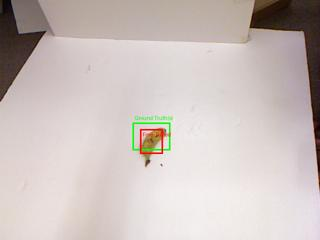
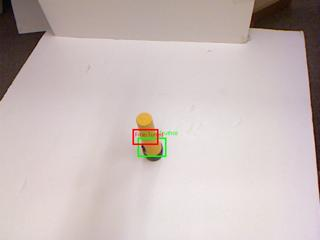
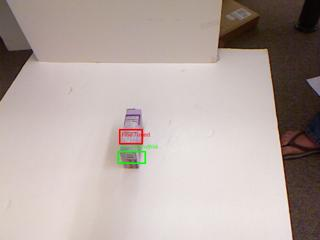
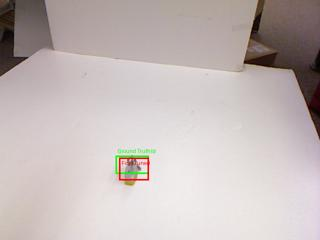

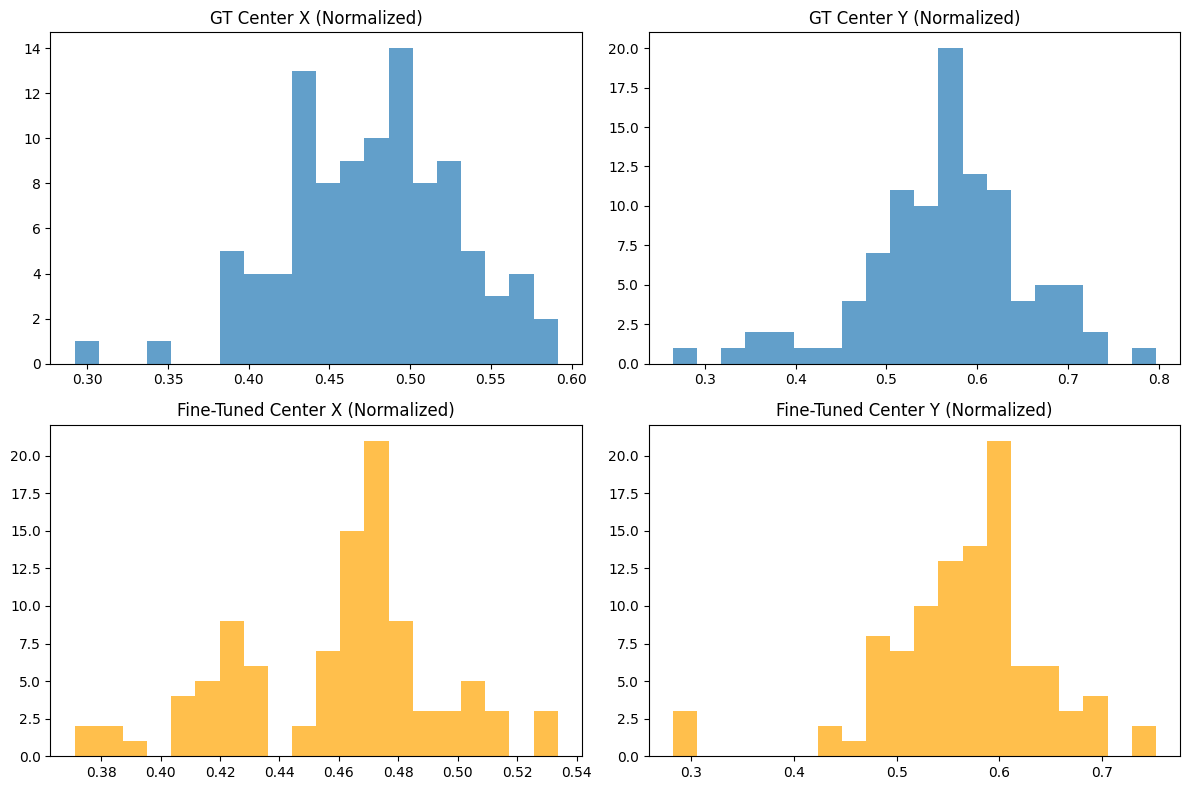

In [ ]:
import time
import gc
from collections import defaultdict
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
import numpy as np
import re
import tensorflow as tf # Needed for tf.TensorSpec in iterator
from PIL import Image
import functools
import random
import matplotlib.pyplot as plt
# --- Assume these are imported or defined elsewhere in your notebook env ---
# import big_vision.utils
# import big_vision.sharding
# from big_vision.models.proj.paligemma import paligemma
# from big_vision.trainers.proj.paligemma import predict_fns
# import ml_collections
# import sentencepiece
# from IPython.display import display, HTML

# --- Assume constants like PROMPT_PREFIX, SEQLEN, ORIGINAL_IMG_WIDTH, ORIGINAL_IMG_HEIGHT,
# MODEL_PATH, LLM_VARIANT, TOKENIZER_PATH, model_config, tokenizer, preprocess_image,
# preprocess_tokens, postprocess_tokens, decode_bbox_from_output, calculate_iou,
# calculate_metrics, render_comparison_image_updated, data_sharding, params_sharding,
# val_examples are defined or imported from your training setup. ---

# Ensure the decode function is correctly defined (matching training notebook)
# decode_fn = predict_fns.get_all(model)['decode']
# decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

# --- 1. Define the memory-efficient loading logic (from training script) ---
def is_trainable_param(name, param):
  # Match the training script's logic exactly
  if name.startswith("llm/layers/attn/"): return True
  if name.startswith("llm/"): return False
  if name.startswith("img/"): return False
  # Training script raises ValueError, but for loading, False is safer for unmatched.
  return False

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p.astype(jnp.float16),
                      params, trainable)

# --- 2. Group the validation data ---
# Assuming val_examples is available from your training setup
# parse_ground_truth should be defined or imported
# def parse_ground_truth(suffix_str): ...
validation_data_grouped = defaultdict(list)
for example in val_examples:
    gt_box = parse_ground_truth(example["suffix"]) # Implement or import this
    if gt_box:
        validation_data_grouped[example["image_path"]].append(gt_box)

# --- Function to decode bbox (Copied from your notebook for completeness) ---
def decode_bbox_from_output(output_string):
    """Parses a model's output string to extract bounding box coordinates."""
    loc_values = re.findall(r'<loc(\d+)>', output_string)
    if len(loc_values) < 4:
        return None
    try:
        vals = [int(v) for v in loc_values[:4]]
        ymin = (vals[0] / 1024) * ORIGINAL_IMG_HEIGHT
        xmin = (vals[1] / 1024) * ORIGINAL_IMG_WIDTH
        ymax = (vals[2] / 1024) * ORIGINAL_IMG_HEIGHT
        xmax = (vals[3] / 1024) * ORIGINAL_IMG_WIDTH
        return [int(xmin), int(ymin), int(xmax), int(ymax)]
    except (ValueError, IndexError) as e:
        return None

# --- Function to calculate metrics (Implement or import) ---
def calculate_metrics(tp, fp, fn):
    """Calculates precision, recall, and F1-score."""
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return {"precision": precision, "recall": recall, "f1_score": f1_score}


# --- 4. Evaluate the FINE-TUNED Model on the GPU ---
print("\n--- Evaluating Fine-Tuned Model (on GPU) ---")
# Load params from disk into RAM
finetuned_model_path = '/content/Cornell_Grasp_Kaggle/my-custom-paligemma-ckpt.npz' # Path to your checkpoint
params_finetuned = paligemma.load(None, finetuned_model_path, model_config)
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params_finetuned)
print("✅ Fine-tuned model loaded into RAM.")

# Move params to GPU memory efficiently
params_finetuned, treedef = jax.tree.flatten(params_finetuned)
# >>>> CRITICAL FIX: Generate NEW sharding_leaves for the fine-tuned model <<<<
sharding_leaves_ft = jax.tree.leaves(params_sharding) # <-- NEW variable for FINE-TUNED model
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(tqdm(zip(sharding_leaves_ft, trainable_leaves), total=len(sharding_leaves_ft), desc="Moving Fine-Tuned Model to GPU")):
  params_finetuned[idx] = big_vision.utils.reshard(params_finetuned[idx], sharding)
  params_finetuned[idx] = maybe_cast_to_f32(params_finetuned[idx], trainable)
  params_finetuned[idx].block_until_ready()
params_finetuned = jax.tree.unflatten(treedef, params_finetuned)
print("✅ Fine-tuned model is on the GPU.")

# Run evaluation loop (on the SAME subset of images for fair comparison)
tp_ft, fp_ft, fn_ft = 0, 0, 0

# Get the list of unique image paths for a controlled evaluation
unique_image_paths_list = list(validation_data_grouped.keys())

# --- CHANGE THIS NUMBER TO REDUCE EVALUATION SIZE ---
NUM_EVAL_EXAMPLES = 100 # e.g., change to 20
unique_image_paths_list = unique_image_paths_list[:NUM_EVAL_EXAMPLES]
# Create a temporary dict for quick lookup of gt_boxes by path
gt_lookup = {path: boxes for path, boxes in validation_data_grouped.items() if path in unique_image_paths_list}
# Create a set for quick lookup of paths we want to evaluate
image_paths_set = set(unique_image_paths_list)
# --- END CHANGE ---

# --- Create a temporary validation iterator that yields only the images we want ---
# Define IMAGE_SIZE constant needed for tf.data
IMAGE_SIZE = 224 # This is the size images are resized to by preprocess_image

def temp_validation_iterator_for_eval(image_paths_subset):
    """A temporary iterator that yields validation examples for a specific subset of image paths."""
    for original_example in val_examples:
        if original_example["image_path"] in image_paths_subset:
            image = Image.open(original_example["image_path"])
            image_processed = preprocess_image(image)
            tokens, mask_ar, _, mask_input = preprocess_tokens(
                prefix=PROMPT_PREFIX, seqlen=SEQLEN
            )
            yield {
                "image": image_processed,
                "text": tokens,
                "mask_ar": mask_ar,
                "mask_input": mask_input,
                "_mask": np.array(True),
                "image_path": original_example["image_path"] # Include for easy lookup
            }

eval_iterator_ft = temp_validation_iterator_for_eval(image_paths_set) # Use the set defined earlier

examples_buffer_ft = []
example_count_ft = 0
debug_print_count_ft = 0
DEBUG_PRINT_LIMIT_FT = 3

# Lists for histogram centers
gt_centers_x, gt_centers_y = [], []
pred_centers_x, pred_centers_y = [], []

visualization_preds = {}

batch_size_for_eval = 4 # Use same batch size as training eval for consistency

eval_pbar_ft = tqdm(total=len(unique_image_paths_list), desc="Fine-Tuned Model GPU Eval (Iterator)")

while True:
    try:
        examples_buffer_ft.append(next(eval_iterator_ft))
        eval_pbar_ft.update(1)
    except StopIteration:
        if not examples_buffer_ft:
            break
        while len(examples_buffer_ft) % batch_size_for_eval != 0:
             padded_example = dict(examples_buffer_ft[-1])
             padded_example["_mask"] = np.array(False)
             examples_buffer_ft.append(padded_example)

    if len(examples_buffer_ft) >= batch_size_for_eval and len(examples_buffer_ft) % batch_size_for_eval == 0:
        current_batch_examples = examples_buffer_ft[:batch_size_for_eval]
        examples_buffer_ft = examples_buffer_ft[batch_size_for_eval:]

        if current_batch_examples:
            # Construct batch dict, carefully excluding string/object dtypes
            numeric_keys = ["image", "text", "mask_ar", "mask_input", "_mask"]
            try:
                batch = {k: np.stack([ex[k] for ex in current_batch_examples]) for k in numeric_keys if k in current_batch_examples[0]}
            except ValueError as e:
                 print(f"  [Error] Failed to stack batch for keys {numeric_keys}: {e}")
                 raise

            batch = big_vision.utils.reshard(batch, data_sharding)

            # --- Make predictions ---
            pred_tokens = decode({"params": params_finetuned}, batch=batch, max_decode_len=SEQLEN)

            # --- Process outputs ---
            pred_tokens_cpu, mask_cpu = jax.device_get((pred_tokens, batch["_mask"]))
            valid_pred_tokens = pred_tokens_cpu[mask_cpu]
            valid_batch_examples = [ex for ex, is_valid in zip(current_batch_examples, mask_cpu) if is_valid]

            for i, (example, raw_pred_toks) in enumerate(zip(valid_batch_examples, valid_pred_tokens)):
                image_path = example["image_path"]
                all_gt_boxes = gt_lookup.get(image_path, [])

                post_processed_text = postprocess_tokens(raw_pred_toks)
                pred_box = decode_bbox_from_output(post_processed_text)

                # --- DEBUGGING: Add prints for first few examples ---
                if debug_print_count_ft < DEBUG_PRINT_LIMIT_FT:
                    print(f"\n--- DEBUG: Fine-Tuned Model Eval, Image {debug_print_count_ft} ({image_path}) ---")
                    print(f"  Input Image Shape: {example['image'].shape}")
                    print(f"  Input Tokens (first 10): {example['text'][:10]}")
                    print(f"  Input Mask AR (first 10): {example['mask_ar'][:10]}")
                    print(f"  Raw Predicted Tokens (first 10): {raw_pred_toks[:10]}")
                    print(f"  Post-processed Text: '{post_processed_text}'")
                    print(f"  Extracted BBox: {pred_box}")
                    print("----------------------------------------")
                    debug_print_count_ft += 1

                if pred_box:
                    is_match = any(calculate_iou(gt, pred_box) >= 0.5 for gt in all_gt_boxes)
                    if is_match: tp_ft += 1
                    else: fp_ft += 1
                else:
                    fn_ft += 1

                # Collect for histograms
                if all_gt_boxes:
                    rand_gt = random.choice(all_gt_boxes)
                    gt_center_x = (rand_gt[0] + rand_gt[2]) / 2 / ORIGINAL_IMG_WIDTH
                    gt_center_y = (rand_gt[1] + rand_gt[3]) / 2 / ORIGINAL_IMG_HEIGHT
                    gt_centers_x.append(gt_center_x)
                    gt_centers_y.append(gt_center_y)

                if pred_box:
                    pred_center_x = (pred_box[0] + pred_box[2]) / 2 / ORIGINAL_IMG_WIDTH
                    pred_center_y = (pred_box[1] + pred_box[3]) / 2 / ORIGINAL_IMG_HEIGHT
                    pred_centers_x.append(pred_center_x)
                    pred_centers_y.append(pred_center_y)

                # Update visualization dict
                if example_count_ft < 4:
                     visualization_preds[image_path] = {'gt': all_gt_boxes, 'finetuned_pred': pred_box}

                example_count_ft += 1
                if example_count_ft >= len(unique_image_paths_list):
                    break

        if example_count_ft >= len(unique_image_paths_list):
            break

eval_pbar_ft.close()
# --- End of Batch processing loop for fine-tuned model ---
metrics_ft = calculate_metrics(tp_ft, fp_ft, fn_ft)
print("✅ Evaluation complete for fine-tuned model.")

del params_finetuned, trainable_mask, trainable_leaves, sharding_leaves_ft
jax.clear_caches()
gc.collect()
print("🧹 Fine-tuned model cleared from GPU memory.")


# --- 5. Final Comparison and Visualization ---
print("\n--- Final Evaluation Results ---")
print(f"{'Metric':<12} | {'Fine-Tuned Model':<20}")
print("-" * 55)
print(f"{'Precision':<12} | {metrics_ft['precision']:.4f}")
print(f"{'Recall':<12} | {metrics_ft['recall']:.4f}")
print(f"{'F1-Score':<12} | {metrics_ft['f1_score']:.4f}")
print("-" * 55)

# Render the visualizations using the saved predictions (if function exists)
print("\n--- Visual Comparison ---")
print("🟩 Ground Truth(s) | 🟥 Fine-Tuned")
html_output = ""
for image_path, preds in visualization_preds.items():
    # Check if we have predictions for both models for this image
    if 'finetuned_pred' in preds:
        html_output += render_comparison_image_updated(
            image_path,
            preds['gt'],
            None,  # No default
            preds.get('finetuned_pred')
        )
display(HTML(html_output))

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
bins = 20

axs[0, 0].hist(gt_centers_x, bins=bins, alpha=0.7, label='GT')
axs[0, 0].set_title('GT Center X (Normalized)')
axs[0, 1].hist(gt_centers_y, bins=bins, alpha=0.7, label='GT')
axs[0, 1].set_title('GT Center Y (Normalized)')

axs[1, 0].hist(pred_centers_x, bins=bins, alpha=0.7, label='Fine-Tuned', color='orange')
axs[1, 0].set_title('Fine-Tuned Center X (Normalized)')
axs[1, 1].hist(pred_centers_y, bins=bins, alpha=0.7, label='Fine-Tuned', color='orange')
axs[1, 1].set_title('Fine-Tuned Center Y (Normalized)')

plt.tight_layout()
plt.show()

In [ ]:
import time
import gc
from collections import defaultdict
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
import numpy as np
import re
import tensorflow as tf # Needed for tf.TensorSpec in iterator
from PIL import Image
import functools
import random
import matplotlib.pyplot as plt
# --- Assume these are imported or defined elsewhere in your notebook env ---
# import big_vision.utils
# import big_vision.sharding
# from big_vision.models.proj.paligemma import paligemma
# from big_vision.trainers.proj.paligemma import predict_fns
# import ml_collections
# import sentencepiece
# from IPython.display import display, HTML

# --- Assume constants like PROMPT_PREFIX, SEQLEN, ORIGINAL_IMG_WIDTH, ORIGINAL_IMG_HEIGHT,
# MODEL_PATH, LLM_VARIANT, TOKENIZER_PATH, model_config, tokenizer, preprocess_image,
# preprocess_tokens, postprocess_tokens, decode_bbox_from_output, calculate_iou,
# calculate_metrics, render_comparison_image_updated, data_sharding, params_sharding,
# val_examples are defined or imported from your training setup. ---

# Ensure the decode function is correctly defined (matching training notebook)
# decode_fn = predict_fns.get_all(model)['decode']
# decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

# --- 1. Define the memory-efficient loading logic (from training script) ---
def is_trainable_param(name, param):
  # Match the training script's logic exactly
  if name.startswith("llm/layers/attn/"): return True
  if name.startswith("llm/"): return False
  if name.startswith("img/"): return False
  # Training script raises ValueError, but for loading, False is safer for unmatched.
  return False

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p.astype(jnp.float16),
                      params, trainable)

# --- 2. Group the validation data ---
# Assuming val_examples is available from your training setup
# parse_ground_truth should be defined or imported
# def parse_ground_truth(suffix_str): ...
validation_data_grouped = defaultdict(list)
for example in val_examples:
    gt_box = parse_ground_truth(example["suffix"]) # Implement or import this
    if gt_box:
        validation_data_grouped[example["image_path"]].append(gt_box)

# --- Function to decode bbox (Copied from your notebook for completeness) ---
def decode_bbox_from_output(output_string):
    """Parses a model's output string to extract bounding box coordinates."""
    loc_values = re.findall(r'<loc(\d+)>', output_string)
    if len(loc_values) < 4:
        return None
    try:
        vals = [int(v) for v in loc_values[:4]]
        ymin = (vals[0] / 1024) * ORIGINAL_IMG_HEIGHT
        xmin = (vals[1] / 1024) * ORIGINAL_IMG_WIDTH
        ymax = (vals[2] / 1024) * ORIGINAL_IMG_HEIGHT
        xmax = (vals[3] / 1024) * ORIGINAL_IMG_WIDTH
        return [int(xmin), int(ymin), int(xmax), int(ymax)]
    except (ValueError, IndexError) as e:
        return None

# --- Function to calculate metrics (Implement or import) ---
def calculate_metrics(tp, fp, fn):
    """Calculates precision, recall, and F1-score."""
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return {"precision": precision, "recall": recall, "f1_score": f1_score}


# --- 4. Evaluate the FINE-TUNED Model on the GPU ---
print("\n--- Evaluating Fine-Tuned Model (on GPU) ---")
# Load params from disk into RAM
finetuned_model_path = '/content/Cornell_Grasp_Kaggle/my-custom-paligemma-ckpt.npz' # Path to your checkpoint
params_finetuned = paligemma.load(None, finetuned_model_path, model_config)
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params_finetuned)
print("✅ Fine-tuned model loaded into RAM.")

# Move params to GPU memory efficiently
params_finetuned, treedef = jax.tree.flatten(params_finetuned)
# >>>> CRITICAL FIX: Generate NEW sharding_leaves for the fine-tuned model <<<<
sharding_leaves_ft = jax.tree.leaves(params_sharding) # <-- NEW variable for FINE-TUNED model
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(tqdm(zip(sharding_leaves_ft, trainable_leaves), total=len(sharding_leaves_ft), desc="Moving Fine-Tuned Model to GPU")):
  params_finetuned[idx] = big_vision.utils.reshard(params_finetuned[idx], sharding)
  params_finetuned[idx] = maybe_cast_to_f32(params_finetuned[idx], trainable)
  params_finetuned[idx].block_until_ready()
params_finetuned = jax.tree.unflatten(treedef, params_finetuned)
print("✅ Fine-tuned model is on the GPU.")

# Run evaluation loop (on the SAME subset of images for fair comparison)
tp_ft, fp_ft, fn_ft = 0, 0, 0

# Get the list of unique image paths for a controlled evaluation
unique_image_paths_list = list(validation_data_grouped.keys())

# --- CHANGE THIS NUMBER TO REDUCE EVALUATION SIZE ---
NUM_EVAL_EXAMPLES = 20 # e.g., change to 20
unique_image_paths_list = unique_image_paths_list[:NUM_EVAL_EXAMPLES]
# Create a temporary dict for quick lookup of gt_boxes by path
gt_lookup = {path: boxes for path, boxes in validation_data_grouped.items() if path in unique_image_paths_list}
# Create a set for quick lookup of paths we want to evaluate
image_paths_set = set(unique_image_paths_list)
# --- END CHANGE ---

# --- Create a temporary validation iterator that yields only the images we want ---
# Define IMAGE_SIZE constant needed for tf.data
IMAGE_SIZE = 224 # This is the size images are resized to by preprocess_image

def temp_validation_iterator_for_eval(image_paths_subset):
    """A temporary iterator that yields validation examples for a specific subset of image paths."""
    for original_example in val_examples:
        if original_example["image_path"] in image_paths_subset:
            image = Image.open(original_example["image_path"])
            image_processed = preprocess_image(image)
            tokens, mask_ar, _, mask_input = preprocess_tokens(
                prefix=PROMPT_PREFIX, seqlen=SEQLEN
            )
            yield {
                "image": image_processed,
                "text": tokens,
                "mask_ar": mask_ar,
                "mask_input": mask_input,
                "_mask": np.array(True),
                "image_path": original_example["image_path"] # Include for easy lookup
            }

eval_iterator_ft = temp_validation_iterator_for_eval(image_paths_set) # Use the set defined earlier

examples_buffer_ft = []
example_count_ft = 0
debug_print_count_ft = 0
DEBUG_PRINT_LIMIT_FT = 3

# Lists for histogram centers
gt_centers_x, gt_centers_y = [], []
pred_centers_x, pred_centers_y = [], []

visualization_preds = {}

batch_size_for_eval = 4 # Use same batch size as training eval for consistency

eval_pbar_ft = tqdm(total=len(unique_image_paths_list), desc="Fine-Tuned Model GPU Eval (Iterator)")

while True:
    try:
        examples_buffer_ft.append(next(eval_iterator_ft))
        eval_pbar_ft.update(1)
    except StopIteration:
        if not examples_buffer_ft:
            break
        while len(examples_buffer_ft) % batch_size_for_eval != 0:
             padded_example = dict(examples_buffer_ft[-1])
             padded_example["_mask"] = np.array(False)
             examples_buffer_ft.append(padded_example)

    if len(examples_buffer_ft) >= batch_size_for_eval and len(examples_buffer_ft) % batch_size_for_eval == 0:
        current_batch_examples = examples_buffer_ft[:batch_size_for_eval]
        examples_buffer_ft = examples_buffer_ft[batch_size_for_eval:]

        if current_batch_examples:
            # Construct batch dict, carefully excluding string/object dtypes
            numeric_keys = ["image", "text", "mask_ar", "mask_input", "_mask"]
            try:
                batch = {k: np.stack([ex[k] for ex in current_batch_examples]) for k in numeric_keys if k in current_batch_examples[0]}
            except ValueError as e:
                 print(f"  [Error] Failed to stack batch for keys {numeric_keys}: {e}")
                 raise

            batch = big_vision.utils.reshard(batch, data_sharding)

            # --- Make predictions ---
            pred_tokens = decode({"params": params_finetuned}, batch=batch, max_decode_len=SEQLEN)

            # --- Process outputs ---
            pred_tokens_cpu, mask_cpu = jax.device_get((pred_tokens, batch["_mask"]))
            valid_pred_tokens = pred_tokens_cpu[mask_cpu]
            valid_batch_examples = [ex for ex, is_valid in zip(current_batch_examples, mask_cpu) if is_valid]

            for i, (example, raw_pred_toks) in enumerate(zip(valid_batch_examples, valid_pred_tokens)):
                image_path = example["image_path"]
                all_gt_boxes = gt_lookup.get(image_path, [])

                post_processed_text = postprocess_tokens(raw_pred_toks)
                pred_box = decode_bbox_from_output(post_processed_text)

                # --- DEBUGGING: Add prints for first few examples ---
                if debug_print_count_ft < DEBUG_PRINT_LIMIT_FT:
                    print(f"\n--- DEBUG: Fine-Tuned Model Eval, Image {debug_print_count_ft} ({image_path}) ---")
                    print(f"  Input Image Shape: {example['image'].shape}")
                    print(f"  Input Tokens (first 10): {example['text'][:10]}")
                    print(f"  Input Mask AR (first 10): {example['mask_ar'][:10]}")
                    print(f"  Raw Predicted Tokens (first 10): {raw_pred_toks[:10]}")
                    print(f"  Post-processed Text: '{post_processed_text}'")
                    print(f"  Extracted BBox: {pred_box}")
                    print("----------------------------------------")
                    debug_print_count_ft += 1

                if pred_box:
                    is_match = any(calculate_iou(gt, pred_box) >= 0.5 for gt in all_gt_boxes)
                    if is_match: tp_ft += 1
                    else: fp_ft += 1
                else:
                    fn_ft += 1

                # Collect for histograms
                if all_gt_boxes:
                    rand_gt = random.choice(all_gt_boxes)
                    gt_center_x = (rand_gt[0] + rand_gt[2]) / 2 / ORIGINAL_IMG_WIDTH
                    gt_center_y = (rand_gt[1] + rand_gt[3]) / 2 / ORIGINAL_IMG_HEIGHT
                    gt_centers_x.append(gt_center_x)
                    gt_centers_y.append(gt_center_y)

                if pred_box:
                    pred_center_x = (pred_box[0] + pred_box[2]) / 2 / ORIGINAL_IMG_WIDTH
                    pred_center_y = (pred_box[1] + pred_box[3]) / 2 / ORIGINAL_IMG_HEIGHT
                    pred_centers_x.append(pred_center_x)
                    pred_centers_y.append(pred_center_y)

                # Update visualization dict
                if example_count_ft < 4:
                     visualization_preds[image_path] = {'gt': all_gt_boxes, 'finetuned_pred': pred_box}

                example_count_ft += 1
                if example_count_ft >= len(unique_image_paths_list):
                    break

        if example_count_ft >= len(unique_image_paths_list):
            break

eval_pbar_ft.close()
# --- End of Batch processing loop for fine-tuned model ---
metrics_ft = calculate_metrics(tp_ft, fp_ft, fn_ft)
print("✅ Evaluation complete for fine-tuned model.")

del params_finetuned, trainable_mask, trainable_leaves, sharding_leaves_ft
jax.clear_caches()
gc.collect()
print("🧹 Fine-tuned model cleared from GPU memory.")


# --- 5. Final Comparison and Visualization ---
print("\n--- Final Evaluation Results ---")
print(f"{'Metric':<12} | {'Fine-Tuned Model':<20}")
print("-" * 55)
print(f"{'Precision':<12} | {metrics_ft['precision']:.4f}")
print(f"{'Recall':<12} | {metrics_ft['recall']:.4f}")
print(f"{'F1-Score':<12} | {metrics_ft['f1_score']:.4f}")
print("-" * 55)

# Render the visualizations using the saved predictions (if function exists)
print("\n--- Visual Comparison ---")
print("🟩 Ground Truth(s) | 🟥 Fine-Tuned")
html_output = ""
for image_path, preds in visualization_preds.items():
    # Check if we have predictions for both models for this image
    if 'finetuned_pred' in preds:
        html_output += render_comparison_image_updated(
            image_path,
            preds['gt'],
            None,  # No default
            preds.get('finetuned_pred')
        )
display(HTML(html_output))

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
bins = 20

axs[0, 0].hist(gt_centers_x, bins=bins, alpha=0.7, label='GT')
axs[0, 0].set_title('GT Center X (Normalized)')
axs[0, 1].hist(gt_centers_y, bins=bins, alpha=0.7, label='GT')
axs[0, 1].set_title('GT Center Y (Normalized)')

axs[1, 0].hist(pred_centers_x, bins=bins, alpha=0.7, label='Fine-Tuned', color='orange')
axs[1, 0].set_title('Fine-Tuned Center X (Normalized)')
axs[1, 1].hist(pred_centers_y, bins=bins, alpha=0.7, label='Fine-Tuned', color='orange')
axs[1, 1].set_title('Fine-Tuned Center Y (Normalized)')

plt.tight_layout()
plt.show()

--- Evaluating Default Model (on GPU) ---
✅ Default model loaded into RAM.


Moving Default Model to GPU:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Default model is on the GPU.


Default Model GPU Eval (Iterator):   0%|          | 0/20 [00:00<?, ?it/s]


--- DEBUG: Default Model Eval, Image 0 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/03/pcd0388r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0)]
  Raw Predicted Tokens (first 10): [235322   2685 235308 235274 235284   2577   2685 235310 235310 235321]
  Post-processed Text: '<loc512><loc448><loc618><loc507> grasp'
  Extracted BBox: [280, 240, 316, 289]
----------------------------------------

--- DEBUG: Default Model Eval, Image 1 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/06/pcd0659r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0), array

Moving Fine-Tuned Model to GPU:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Fine-tuned model is on the GPU.


Fine-Tuned Model GPU Eval (Iterator):   0%|          | 0/20 [00:00<?, ?it/s]


--- DEBUG: Fine-Tuned Model Eval, Image 0 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/03/pcd0388r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0)]
  Raw Predicted Tokens (first 10): [1 0 0 0 0 0 0 0 0 0]
  Post-processed Text: ''
  Extracted BBox: None
----------------------------------------

--- DEBUG: Fine-Tuned Model Eval, Image 1 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/06/pcd0659r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0)]
  Raw Predict

--- Evaluating Default Model (on GPU) ---
✅ Default model loaded into RAM.


Moving Default Model to GPU:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Default model is on the GPU.


Default Model GPU Eval:   0%|          | 0/375 [00:00<?, ?it/s]

✅ Evaluation complete for default model.
🧹 Default model cleared from GPU memory.

--- Evaluating Fine-Tuned Model (on GPU) ---
✅ Fine-tuned model loaded into RAM.


Moving Fine-Tuned Model to GPU:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Fine-tuned model is on the GPU.


Fine-Tuned Model GPU Eval:   0%|          | 0/375 [00:00<?, ?it/s]

✅ Evaluation complete for fine-tuned model.
🧹 Fine-tuned model cleared from GPU memory.

--- Final Evaluation Results ---
Metric       | Fine-Tuned Model     | Default Model
-------------------------------------------------------
Precision    | 0.1360                | 0.0000
Recall       | 1.0000                | 0.0000
F1-Score     | 0.2394                | 0.0000
-------------------------------------------------------

--- Visual Comparison ---
🟩 Ground Truth(s) | 🟥 Fine-Tuned | 🟦 Default (dashed)



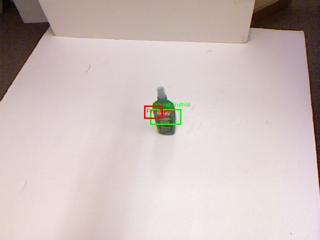
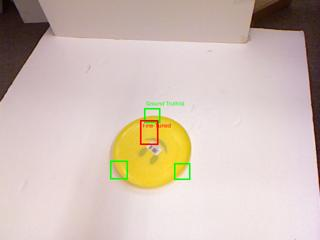
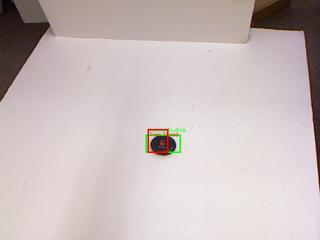
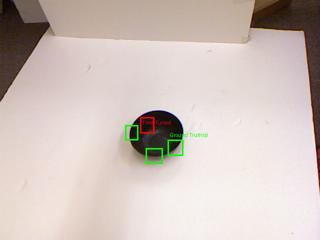

In [ ]:
# ==============================================================================
#
#               FINAL GPU EVALUATION SCRIPT
#
# ==============================================================================
import time
import gc
from collections import defaultdict
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
import numpy as np

# --- 1. Define the memory-efficient loading logic from your training script ---

# This mask determines which params are cast to float32 (trainable) vs float16 (frozen)
def is_trainable_param(name, param):
  if name.startswith("llm/layers/attn/"): return True
  return False

# This JIT'd function efficiently casts the parameters on the device
@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p.astype(jnp.float16),
                      params, trainable)

# --- 2. Group the validation data ---
validation_data_grouped = defaultdict(list)
for example in val_examples:
    gt_box = parse_ground_truth(example["suffix"])
    if gt_box:
        validation_data_grouped[example["image_path"]].append(gt_box)

# --- 3. Evaluate the DEFAULT Model on the GPU ---

print("--- Evaluating Default Model (on GPU) ---")
# Load params from disk into RAM
default_model_path = MODEL_PATH
params_default = paligemma.load(None, default_model_path, model_config)
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params_default)
print("✅ Default model loaded into RAM.")

# Move params to GPU memory efficiently, param by param
params_default, treedef = jax.tree.flatten(params_default)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(tqdm(zip(sharding_leaves, trainable_leaves), total=len(sharding_leaves), desc="Moving Default Model to GPU")):
  params_default[idx] = big_vision.utils.reshard(params_default[idx], sharding)
  params_default[idx] = maybe_cast_to_f32(params_default[idx], trainable)
params_default = jax.tree.unflatten(treedef, params_default)
print("✅ Default model is on the GPU.")

# Run evaluation loop
tp_def, fp_def, fn_def = 0, 0, 0
unique_image_paths = list(validation_data_grouped.keys())
visualization_preds = {}

for i, image_path in enumerate(tqdm(unique_image_paths, desc="Default Model GPU Eval")):
    all_gt_boxes = validation_data_grouped[image_path]
    image = preprocess_image(Image.open(image_path))
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix=PROMPT_PREFIX, seqlen=SEQLEN)
    batch = {
        "image": np.array([image]), "text": np.array([tokens]),
        "mask_input": np.array([mask_input]), "mask_ar": np.array([mask_ar]),
        "_mask": np.array([True])
    }
    batch = big_vision.utils.reshard(batch, data_sharding)

    pred_tok = decode({"params": params_default}, batch=batch, max_decode_len=SEQLEN)
    pred_box = decode_bbox_from_output(postprocess_tokens(jax.device_get(pred_tok)[0]))

    if pred_box:
        is_match = any(calculate_iou(gt, pred_box) >= 0.5 for gt in all_gt_boxes)
        if is_match: tp_def += 1
        else: fp_def += 1
    else:
        fn_def += 1
    if i < 4:
        visualization_preds[image_path] = {'gt': all_gt_boxes, 'default_pred': pred_box}

metrics_def = calculate_metrics(tp_def, fp_def, fn_def)
print("✅ Evaluation complete for default model.")

# CRITICAL STEP: Clear model from GPU memory
del params_default, trainable_mask, trainable_leaves
jax.clear_caches()
gc.collect()
print("🧹 Default model cleared from GPU memory.")


# --- 4. Evaluate the FINE-TUNED Model on the GPU ---

print("\n--- Evaluating Fine-Tuned Model (on GPU) ---")
# Load params from disk into RAM
finetuned_model_path = '/content/Cornell_Grasp_Kaggle/my-custom-paligemma-ckpt.npz'
params_finetuned = paligemma.load(None, finetuned_model_path, model_config)
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params_finetuned)
print("✅ Fine-tuned model loaded into RAM.")

# Move params to GPU memory efficiently
params_finetuned, treedef = jax.tree.flatten(params_finetuned)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(tqdm(zip(sharding_leaves, trainable_leaves), total=len(sharding_leaves), desc="Moving Fine-Tuned Model to GPU")):
  params_finetuned[idx] = big_vision.utils.reshard(params_finetuned[idx], sharding)
  params_finetuned[idx] = maybe_cast_to_f32(params_finetuned[idx], trainable)
params_finetuned = jax.tree.unflatten(treedef, params_finetuned)
print("✅ Fine-tuned model is on the GPU.")

# Run evaluation loop
tp_ft, fp_ft, fn_ft = 0, 0, 0
for i, image_path in enumerate(tqdm(unique_image_paths, desc="Fine-Tuned Model GPU Eval")):
    all_gt_boxes = validation_data_grouped[image_path]
    image = preprocess_image(Image.open(image_path))
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix=PROMPT_PREFIX, seqlen=SEQLEN)
    batch = {
        "image": np.array([image]), "text": np.array([tokens]),
        "mask_input": np.array([mask_input]), "mask_ar": np.array([mask_ar]),
        "_mask": np.array([True])
    }
    batch = big_vision.utils.reshard(batch, data_sharding)
    pred_tok = decode({"params": params_finetuned}, batch=batch, max_decode_len=SEQLEN)
    pred_box = decode_bbox_from_output(postprocess_tokens(jax.device_get(pred_tok)[0]))

    if pred_box:
        is_match = any(calculate_iou(gt, pred_box) >= 0.5 for gt in all_gt_boxes)
        if is_match: tp_ft += 1
        else: fp_ft += 1
    else:
        fn_ft += 1
    if i < 4:
        visualization_preds[image_path]['finetuned_pred'] = pred_box

metrics_ft = calculate_metrics(tp_ft, fp_ft, fn_ft)
print("✅ Evaluation complete for fine-tuned model.")

del params_finetuned, trainable_mask, trainable_leaves
jax.clear_caches()
gc.collect()
print("🧹 Fine-tuned model cleared from GPU memory.")


# --- 5. Final Comparison and Visualization ---
print("\n--- Final Evaluation Results ---")
print(f"{'Metric':<12} | {'Fine-Tuned Model':<20} | {'Default Model'}")
print("-" * 55)
print(f"{'Precision':<12} | {metrics_ft['precision']:.4f}{'':<15} | {metrics_def['precision']:.4f}")
print(f"{'Recall':<12} | {metrics_ft['recall']:.4f}{'':<15} | {metrics_def['recall']:.4f}")
print(f"{'F1-Score':<12} | {metrics_ft['f1_score']:.4f}{'':<15} | {metrics_def['f1_score']:.4f}")
print("-" * 55)

# Render the visualizations using the saved predictions
print("\n--- Visual Comparison ---")
print("🟩 Ground Truth(s) | 🟥 Fine-Tuned | 🟦 Default (dashed)")
html_output = ""
for image_path, preds in visualization_preds.items():
    html_output += render_comparison_image_updated(
        image_path,
        preds['gt'],
        preds.get('default_pred'),
        preds.get('finetuned_pred')
    )
display(HTML(html_output))